In [1]:
%pylab inline
from scipy.optimize import minimize
from scipy.optimize import OptimizeResult
from scipy.io import loadmat
from sklearn.preprocessing import PolynomialFeatures
from IPython.core.debugger import set_trace
import doctest

Populating the interactive namespace from numpy and matplotlib


## Load Data

In [2]:
ex4data1 = loadmat('ex4data1.mat')
X,y = np.ascontiguousarray(ex4data1['X']), np.ascontiguousarray(ex4data1['y'])
# replace 10 class by 0
y[y[:,0] == 10, 0] = 0

## One Hot Encoder

In [3]:
def one_hot(y,size):
    """Encode categorical integer features using a one-hot aka one-of-K scheme.

    The input to this transformer should be a matrix of integers,
    denoting the values taken on by categorical (discrete) features.
    The output will be a sparse matrix where each column corresponds to one possible value of one feature.
    It is assumed that input features take on values in the range ``[0, size)``.
    
    Parameters
    ----------
    y : int or array of ints
        Integer features, each feature value should be in ``range(size)``.
    
    size: int
        Number of categorical values.
        
    Returns
    -------
    numpy.darray
        Output array of shape ``(len(y), size)``.
        
    Examples
    --------
    >>> one_hot(2,4)
    array([[0., 0., 1., 0.]])
    
    >>> one_hot(np.array([1,0,3,0,6,4]),7)
    array([[0., 1., 0., 0., 0., 0., 0.],
           [1., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 1., 0., 0., 0.],
           [1., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 1.],
           [0., 0., 0., 0., 1., 0., 0.]])
    """
    return eye(size)[y].reshape((-1,size))

ys = one_hot(y,10)

## Plot Sample Data

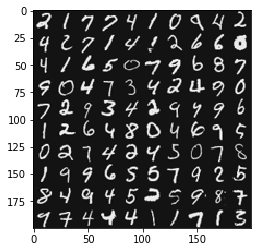

In [4]:
def plot_sample_data(X):
    X_copy = X.copy()
    np.random.shuffle(X_copy)
    img = np.reshape(X_copy[:100], (10,10,20,20)).transpose((0,3,1,2)).reshape((200,200))
    f = plt.imshow(img, cmap='gray');

plot_sample_data(X)

## Load Parameters

In [5]:
ex4weights = loadmat('ex4weights.mat')
t1, t2 = np.ascontiguousarray(ex4weights['Theta1']), np.ascontiguousarray(ex4weights['Theta2']) #(25,401) (10,26)
# we swap rows 0 and 9 because of the indexation starting at 1 in matlab...
t2 = np.roll(t2, 1, axis=0)
thetas = [t1, t2]

## Insert Bias Feature

In [6]:
def insert_bias_feature(X):
    """Insert a column filled with ones in front of an unbiased array of features.
    
    The new column is inserted at index ``0`` on axis ``1``.
    
    Parameters
    ----------
    X : array_like
        Input array.
        The input array must not include the bias column.
        If `X` is a 1-D array of shape ``(m,)``, it will be reshaped to ``(m,1)``
        before the new column insertion.
        
    Returns
    -------
    numpy.ndarray
        Output array.
        If `X` has ``(m,n)`` shape, the return value will have ``(m,n+1)``shape.
        
    Examples
    --------
    >>> x = np.array([[2,3],[4,5],[6,7]])
    >>> insert_bias_feature(x)
    array([[1, 2, 3],
           [1, 4, 5],
           [1, 6, 7]])
     
    >>> x = np.array([[2],[3],[4]])
    >>> insert_bias_feature(x)
    array([[1, 2],
           [1, 3],
           [1, 4]])
     
    >>> x = [2,3,4]
    >>> insert_bias_feature(x)
    array([[1, 2],
           [1, 3],
           [1, 4]])
    """
    if np.ndim(X) == 1:
        X = np.reshape(X, (-1,1))
        
    return np.insert(X,0,1,axis=1)

## Sigmoid Function

In [7]:
def sigmoid(z):
    '''Compute the sigmoid function.
    
    Parameters
    ----------
    z : array_like
        Input data.
        
    Returns
    -------
    numpy.ndarray
        Element-wise ``sigmoid(z)``, of the same shape and dtype as `x`.
        Returns scalar if `x` is a scalar.
        
    Examples
    --------
    >>> sigmoid(0)
    0.5
    
    >>> sigmoid([-1,1])
    array([0.26894142, 0.73105858])

    >>> sigmoid(np.array([-1,1e2]))
    array([0.26894142, 1.        ])
    '''
    return 1 / (1 + np.exp(np.negative(z)))

## Forward Propagation

In [8]:
def feed_forward(thetas, X):
    """Execute neural network Forward Propagation.
    
    Parameters
    ----------
    theta : array_like
        Parameters (weights) of the model, including the bias parameter.
    X : array_like
        Input examples.
        The input array must not include the bias column.
        If `X` is a 1-D array of shape ``(m,)``, it will be reshaped to ``(m,1)``.
        
    Returns
    -------
    activations : array_like
        Array filled with the network's activation layers,
        from input to output, both included.
    
    Examples
    --------
    >>> t1 = [[0.05,0.1,0.15,0.2],
    ...       [0.25,0.3,0.35,0.4],
    ...       [0.45,0.5,0.55,0.6]]
    >>> t2 = [[0.05,0.1,0.15,0.2],
    ...       [0.25,0.3,0.35,0.4]]
    >>> x = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]
    >>> print(feed_forward([t1,t2],x))
    [[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]], array([[0.7407749 , 0.92056145, 0.97916366],
           [0.9168273 , 0.99631576, 0.99984929],
           [0.97702263, 0.99984156, 0.99999893],
           [0.9939402 , 0.99999321, 0.99999999]]), array([[0.61253829, 0.76604183],
           [0.62036552, 0.7813752 ],
           [0.62191356, 0.78466314],
           [0.62231667, 0.78552847]])]
    """ 
    a = X
    activations = []
    activations.append(a)
    for i,t in enumerate(thetas):
        a_biased = insert_bias_feature(a)
        z = a_biased @ np.transpose(t)
        a = sigmoid(z)
        activations.append(a)
    return activations

## Flatten Thetas

In [9]:
def flatten_thetas(thetas):
    t = np.hstack([np.ravel(t,order='C') for t in thetas])
    s = [np.shape(t) for t in thetas]
    return t, s

## Unflatten Thetas

In [10]:
def unflatten_thetas(thetas,shapes):
    indices = np.cumsum([np.multiply(*s) for s in shapes[:-1]])
    chunks = np.split(thetas, indices)
    return [np.reshape(c, s) for c,s in zip(chunks, shapes)]

## Cost Function

In [11]:
def logistic_loss(thetas,shapes,X,y):
    t = unflatten_thetas(thetas,shapes)
    a = feed_forward(t,X)
    output = a[-1]
    J = -(1/len(y)) * np.sum(y*np.log(output) + (1-y)*np.log(1-output))
    return J

In [12]:
def test_logistic_loss(thetas,X,y):
    t, s = flatten_thetas(thetas)
    print(f'The unregularized cost is about {logistic_loss(t,s,X,y)}.')

test_logistic_loss(thetas,X,ys)

The unregularized cost is about 0.2876291651613189.


## Regularized Cost Function

In [13]:
def regularized_logistic_loss(thetas,shapes,X,y,lamb):
    thetas = unflatten_thetas(thetas,shapes)
    a = feed_forward(thetas,X)
    output = a[-1]
    J = -(1/len(y)) * np.sum(y * np.log(output) + (1-y) * np.log(1-output))
    reg = (lamb/(2*len(y))) * np.sum(np.sum(t[:,1:]**2) for t in thetas)
    return np.sum(J + reg)

In [14]:
def test_regularized_logistic_loss(thetas,X,y,lamb=0):
    t, s = flatten_thetas(thetas)
    print(f'The regularized cost is about {regularized_logistic_loss(t,s,X,y,lamb)}.')

test_regularized_logistic_loss(thetas,X,ys,lamb=1)

The regularized cost is about 0.38376985909092365.


## Random Weights Initialization

In [15]:
def initialize_weights(shapes):
    thetas = []
    for s in shapes:
        eps = np.sqrt(6) / np.sqrt(s[1] + s[0])
        thetas.append(np.random.random(s) * 2 * eps - eps)
    return thetas

## Regularized Gradient Function

In [16]:
def regularized_logistic_gradient(thetas,shapes,X,y,lamb=0):
    thetas = unflatten_thetas(thetas,shapes)
    
    # forward propagation
    a = feed_forward(thetas, X)
    
    # back propagation
    gradients = [] # 2
    delta = None
    for i in reversed(range(len(a))): # 2,1,0
        if i == len(a)-1:
            delta = a[i] - y
        else:
            g = (1/len(y)) * delta.T @ insert_bias_feature(a[i])
            g[:,1:] += (lamb/(len(y))) * thetas[i][:,1:]
            gradients.insert(0,g)
            if i > 0:
                delta = delta @ thetas[i][:,1:] * (a[i] * (1 - a[i]))

    return flatten_thetas(gradients)[0]

## Numerical Gradient

In [17]:
def numerical_logistic_gradient(thetas,shapes,X,y,lamb=0):
    gradients = np.zeros(len(thetas))
    t = np.zeros(len(thetas))
    eps = 1e-4
    for i in range(len(thetas)):
        t[i] = eps
        theta_high = thetas + t
        theta_low = thetas - t
        J_high = regularized_logistic_loss(theta_high,shapes,X,y,lamb) 
        J_low = regularized_logistic_loss(theta_low,shapes,X,y,lamb)
        gradients[i] = (J_high - J_low)/ (2*eps)
        t[i] = 0
    return gradients

In [18]:
def test_gradient(thetas,X,y,lamb=0):
    t, s = flatten_thetas(thetas)
    t1 = regularized_logistic_gradient(t,s,X,y,lamb)
    #t1 = tryout_gradient(t,s,X,y,lamb)
    t2 = numerical_logistic_gradient(t,s,X,y,lamb)
    rel_diff =  np.linalg.norm(t2-t1)/np.linalg.norm(t2+t1)
    print(f'The relative difference is about {rel_diff}.')

idx = np.random.randint(0,len(ys),10)
test_gradient(initialize_weights([(25,401),(10,26)]),X[idx,:],ys[idx,:],lamb=0)

The relative difference is about 1.5453165843617122e-10.


## Regularized Gradient Descent

In [19]:
def regularized_logistic_gradient_descent(thetas,X,y,lamb=0,maxiter=400):
    t, s = flatten_thetas(thetas)
    result = minimize(fun=regularized_logistic_loss,
                      x0=t,
                      args=(s,X,y,lamb),
                      jac=regularized_logistic_gradient,
                      method='tnc',
                      options={'maxiter': maxiter})
    return unflatten_thetas(result.x,s)

## Training

In [20]:
def test_train(thetas,X,y,lamb=0,maxiter=400):
    t = regularized_logistic_gradient_descent(thetas,X,y,lamb,maxiter)
    output = feed_forward(t,X)[-1]
    accuracy = np.mean(output.argmax(axis=1) == y.argmax(axis=1))
    print(f'The network has an accuracy of {accuracy*100}%')

test_train(thetas,X,ys,lamb=1,maxiter=400)

The network has an accuracy of 99.62%


## Plot Weights

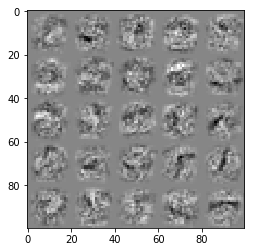

In [21]:
def plot_weights(thetas,X,y,lamb=0,maxiter=400):
    t, _ = regularized_logistic_gradient_descent(thetas,X,y,lamb,maxiter)
    img = np.reshape(t[:,1:].flatten(), (5,5,20,20)).transpose((0,3,1,2)).reshape((100,100))
    f = plt.imshow(img, cmap='gray')
    
plot_weights(thetas,X,ys,lamb=1,maxiter=400)

In [22]:
doctest.testmod()

TestResults(failed=0, attempted=15)

In [23]:
# set the file name (required)
__file__ = 'ex4.ipynb'

# add ipython magics
import ipytest.magics
import pytest

In [28]:
%%run_pytest[clean] -qq -v

def test_one_hot_encoder():
    ipytest.assert_equals(one_hot(2,4),
                          np.array([[0., 0., 1., 0.]]))
    ipytest.assert_equals(one_hot([1,0,3,0,6,4],7),
                         np.array([[0., 1., 0., 0., 0., 0., 0.],
                                   [1., 0., 0., 0., 0., 0., 0.],
                                   [0., 0., 0., 1., 0., 0., 0.],
                                   [1., 0., 0., 0., 0., 0., 0.],
                                   [0., 0., 0., 0., 0., 0., 1.],
                                   [0., 0., 0., 0., 1., 0., 0.]]))

def test_insert_bias_feature():
    ipytest.assert_equals(insert_bias_feature([[2,3], [4,5], [6,7]]),
                          np.array([[1, 2, 3], [1, 4, 5], [1, 6, 7]]))
    ipytest.assert_equals(insert_bias_feature(np.array([[2],[3],[4]])),
                          np.array([[1, 2], [1, 3], [1, 4]]))
    ipytest.assert_equals(insert_bias_feature([2,3,4]),
                          np.array([[1, 2], [1, 3], [1, 4]]))
    
def test_sigmoid():
    ipytest.assert_equals(sigmoid(0), 0.5)
    ipytest.assert_equals(sigmoid([-1,1]), np.array([0.26894142, 0.73105858]))
    ipytest.assert_equals(sigmoid(np.array([-1,1e2])), np.array([0.26894142, 1.]))

...                                                                                                                                                                                                [100%]
3 passed in 0.06 seconds
